# Programming project : path related problems: Constrained shortest path and the k shortest paths

1) 

For the sequential shortest paths problem, we chose to implement Dijktra's algorithm with heap queue. Indeed, as the costs of the arcs are all said to be positive, Dijkstra's shortest path algorithm can be applied and is more efficient than Bellman-Ford's algorithm $(O(|E|+|V|\log(|V|))$ when implemented with heap queue against $O(|E||V|)$).)

This algorithm doesn't only compute a path from $s$ to $t$ minimizing the sum of the costs along its arcs, it actually computes a shortest path tree (shortest path from $s$ to all of the nodes).

Dijkstra's algorithm requires a priority queue structure to stock the pairs (distance,vertices) for which we haven't computed a shortest path yet. To do so we found it easier to use python's library heapq which already provides a heap priority queue.

$\textbf{Classic Dijkstra's algortithm's :}$

The parameters are :


*   s : the source vertex
*   t : the target vertex
*   G : the graph
*   distances : table with minimal distance to source
*   visited : set of vertices already visited
*   queue : priority heap (heapq) containing pairs (distances
(x),x)
*   neighbors : function giving the pairs (weigth, vertex) for all leaving edges
*   previous : keep trak of the previous vertex to reconstruct the path



$\textbf{Input :}$ a directed connected graph $G=(V,A,c)$ with non-negative arc costs $c:A\mapsto \mathbb{R}_+$, a source $s$ and a target $t$.

$\textbf{Output :}$ A shortest path $s\rightarrow t$ as well as its cost.




In [289]:
# libraries needed
import networkx as nx
from heapq import *
import numpy as np
import matplotlib.pyplot as plt
# tqdm is a python library which gives us an indication in real time about the progress of the computations
from tqdm import tqdm

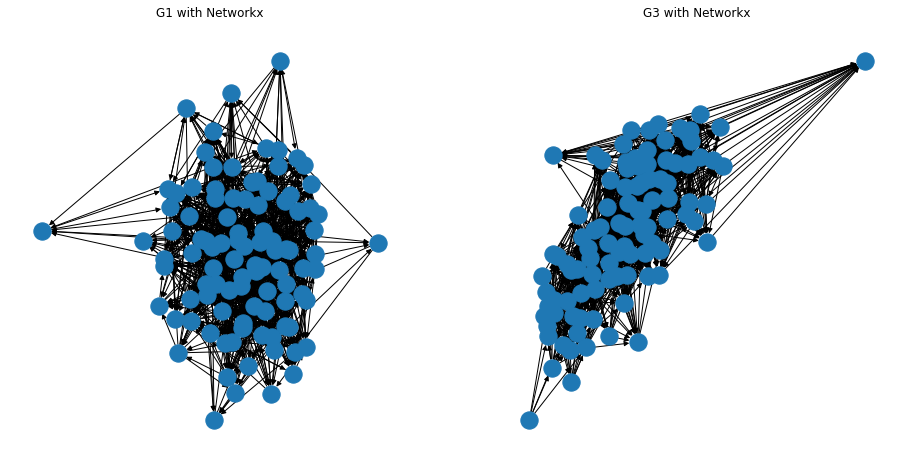

In [310]:
# To build the graphs, we use the library networkx
def makeGraph_nx(data) :
    G = nx.DiGraph()
    lines = np.loadtxt(data)
    
    for vert in lines:
        G.add_node(int(vert[0]-1))
        G.add_edge(int(vert[0]-1), int(vert[1]-1), weight=int(vert[2]))
    return G
    

G1_nx=makeGraph_nx("rcsp1.txt")
G3_nx=makeGraph_nx("rcsp3.txt")


plt.figure(figsize=[16,8])
plt.subplot(121)
plt.title("G1 with Networkx")
nx.draw(G1_nx)

plt.subplot(122)
plt.title("G3 with Networkx")
nx.draw(G3_nx)
plt.show()

In [311]:
# Import data from txt and make it into an adjacency matrix (other method)
def makeGraph(data):
    
    n=100
    value = np.empty((), dtype=object)
    value[()] = (np.inf, np.inf)
    G = np.full((n, n), value, dtype=object)
    
    lines = np.loadtxt(data)
    
    for vert in lines:
        G[int(vert[0])-1][int(vert[1])-1]=(int(vert[2]),int(vert[3]))
    return G


In [312]:
def dijkstra (s, t, G):
    
    # initialization : the only vertex in the priority queue is s with distance 0 
    # (the shortest since no negative arcs)
    visited = set()
    distances = {s: 0}
    previous = {}
    queue = [(0, s)]
    
    # Boolean to tell if we eventually found a path s-t (just a assert because G should be connected)
    targetFound = False

    # We look at the vertex with shortest distance (at top of the heap) while we have'nt visited all the nodes yet
    while queue != []:
        
        # x : next element in the queue, hence the one with distance[w]+cost(w,x) minimal for all w in visited
        dx, x = heappop(queue)
        
        # if x already visited, we don't go through the computations twice !
        if x in visited:
            continue

        visited.add(x)
        
        
        for y in range(len(G[x])):
            
            # we look at each neighbor of x
            if G[x][y][0]!=np.inf :
                
                # if already done :
                if y in visited:
                    continue

                # else : compute the distance s-y passing by x and compare it with the minimum distance we already had
                cost = G[x][y][0]
                dy = dx + cost

                if y not in distances or dy < distances[y]:
                    distances[y] = dy

                    # put it back in the queue with distance updated
                    heappush(queue, (dy, y))

                    # update the path
                    previous[y] = x

                    # check if we found the target
                    if(y==t):
                        targetFound = True

    # then we reconstruct the path s-t (if we have one)               
    path = [t]
    x = t
    if targetFound :
        while x != s:
            x = previous[x]
            path.insert(0, x)
        
        # return the shortest path s-t and its cost
        return distances[t], path
    
    # if there is no path between s and t
    return np.inf

In [326]:
# Tests on the given data :
G1= makeGraph("rcsp1.txt")
G3= makeGraph("rcsp3.txt")

s=0
t=18

print(f"Shortest path between {s} and {t} : with our algorithm")
print(dijkstra (s, t, G1))
print(dijkstra (s, t, G3))

# tests with networkx :
print(f"Verifications : shortest path between {s} and {t} : with networkx's algorithm")
print(nx.shortest_path_length(G1_nx, source=s, target=18, weight="weight"),nx.shortest_path(G1_nx, source=s, target=t, weight="weight"))
print(nx.shortest_path_length(G3_nx, source=s, target=18, weight="weight"),nx.shortest_path(G3_nx, source=s, target=t, weight="weight"))

Shortest path between 0 and 18 : with our algorithm
(105, [0, 58, 88, 11, 26, 18])
(0, [0, 18])
Verifications : shortest path between 0 and 18 : with networkx's algorithm
105 [0, 58, 88, 11, 26, 18]
0 [0, 18]


$\textbf{Parallel Dijkstra algorithm :}$

The idea here is to split the graph in different subgraphes when looking at the neighbors.
The code remains roughly the same except we add a parameter nbCores to determine the number of core working in parallel.

To run the program on different cores we will use the python tool PSim from the library psim.

2) $\textbf{Shortest Path with constraints :}$

Description : 
This problem is known to be NP-hard. We can formulate this problem as an interger linear program :

For a givent $s\rightarrow t$ path $p$, minimize $c(p)=\sum_{(a,b)\in p} c_{ab}$, with $d(p)=\sum_{(a,b) \in p} d_{ab} \leqslant T$

To solve this problem, we can implement a modified version of Dijkstra's algorithm, where only the paths verifying the constraint are examined. To do so, let's add a parameter $delays(v)$ to each vertex $v$ containing the delay of a $s-u$ path and minDelay(u) giving the delay of a minimum $u-t$ path (the later is easily computable by running Dijktra's algorithm from source $u$ to target $t$ with arc costs given by $d$ instead of $c$.

Pseudocode :

$\textbf{Input :}$  a directed connected graph $G=(V,A,c)$ with non-negative arc costs $c$ and non-negative delays, a constraint $T$ a source $s$ and a target $t$.
$\textbf{Output :}$  The shortest path verifying the constraint, or an error message if there is none.

$\textbf{Initialisation :}$ 
* $distances(s)=0$
* $delays(s)=0$
* $visited={s}$
* compute $minDelay$

$\textbf{Step of the algorithm :}$ 
* Pick vertex the vertex $u$ not in $visited$ with minimal $distance$ value while there still are such
* add $u$ to $visited$
* for all neighbors $v$ of $u$, if $delays(u)+d_{uv}+minDelay(v)\leqslant T$ and $distance(v)>distance(u)+c_{uv}$ :
* $distance(v)=distance(u)+c_{uv}$, $delays(v)=delays(u)+d_{uv}$ and $previous(v)=u$

Implementation :

In [222]:
# Dijkstra's algorithm backwards to have the minDelay table described above :
def minDelay (t, G):  
    
    # We reverse the matrix (since the graph is undirect)
    Gbis = G.copy().transpose()
    visited = set()
    minDelay = {t: 0}
    previous = {}
    queue = [(0, t)]
    
    while queue != []:

        dx, x = heappop(queue)

        if x in visited:
            continue
            
        visited.add(x)
        
        for y in range(len(Gbis[x])):
            
            # we look at each neighbor of x
            if Gbis[x][y][1]!=np.inf :
            
                if y in visited:
                    continue
                    
                cost = Gbis[x][y][0]
                delay = Gbis[x][y][1]
                dy = dx + delay

                if y not in minDelay or dy < minDelay[y]:
                    minDelay[y] = dy
                    heappush(queue, (dy, y))

    # Contrary to the previous Dijkstra's algorithm, here we return the table minDelay (equivalent to distances)
    # Giving the path u-t to the target with minimal delay
    return minDelay



def constraintDijkstra(s,t,T,G):
    visited=set()
    distances={s:0}
    delays={s:0}
    previous={}
    queue = [(0,0,s)]
    min_delay=minDelay(t,G)
    
    # Boolean to tell if we eventually found a s-t path satisfying the constraint
    targetFound = False
    
    while queue != [] :
        
        # vertex with minimum distance to s still in the queue
        dist_x, del_x, x = heappop(queue)
        
        # in cas we already done the computation for x :
        if x in visited :
            continue
        
        visited.add(x)
        for y in range(len(G[x])):
            
            # we look at each neighbor of x
            if G[x][y][0] != np.inf and G[x][y][1] != np.inf and y in min_delay :
            
                # we don't do things twice
                if y in visited :
                    continue

                cost = G[x][y][0]
                delay = G[x][y][1]
                dist_y = dist_x + cost
                del_y = del_x + delay
                

                # we check if the constraint is verified before going in the direction y :
                if del_y + min_delay[y] <= T and (y not in distances or dist_y < distances[y]) :
                    
                    # update distances
                    distances[y]=dist_y

                    # update delay
                    delays[y]=del_y

                    # update path
                    previous[y]=x

                    # put it back in the queue with distance updated
                    heappush(queue, (dist_y, del_y, y))

                    if(y==t):
                        targetFound = True

    # then we reconstruct the path s-t (if we have one)               
    path = [t]
    x = t
    if targetFound :
        while x != s:
            x = previous[x]
            path.insert(0, x)
        
        # return the shortest path s-t and its cost
        return distances[t],delays[t], path
    
    # if there are no paths satisfying the constraints, return 0
    return np.inf

In [235]:
# test on the given data :
print(constraintDijkstra(0,8,73,G1))
print(constraintDijkstra(0,8,65,G1))
print(constraintDijkstra(0,8,17,G3))
print(constraintDijkstra(0,8,10,G3))

(158, 72, [0, 36, 40, 44, 91, 8])
(168, 62, [0, 36, 40, 1, 99, 8])
(6, 13, [0, 1, 4, 8])
(7, 10, [0, 4, 8])


In [263]:
# More tests :
def constDist(T,G):
    n=len(G)
    value = np.empty((), dtype=object)
    value = np.inf
    matrix = np.full((n, n), value, dtype=object)
    for i in range(n):
        for j in range(n):
            path=constraintDijkstra(i,j,T,G)
            if path!=np.inf :
                matrix[i][j]=path[0]
    return matrix

In [265]:
T=np.linspace(10,500,10)
Costs=np.array([np.mean(constDist(t,G1)) for t in tqdm(T)])


100%|██████████| 10/10 [35:18<00:00, 211.86s/it]


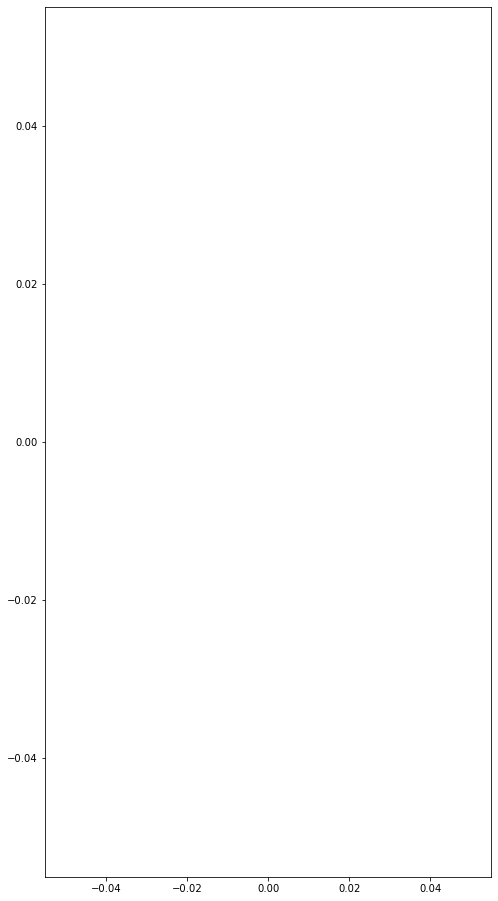

[inf inf inf inf inf inf inf inf inf inf]


In [266]:
plt.figure(figsize=[8,16])
plt.plot(T,Costs)
plt.show()

print(Costs)

The tighter and more exigent the constraint is, the more expensive the shortest path is, which is coherent with our intuition

3) $K$ $\textbf{- Shortest Paths}$

Description : We want the $K$-shortest paths connecting the source $s$ to the target $t$. The easiest is to keep these paths in an array $bestPaths$ where $bestPaths[i]$ will give the $k^{th}$ shortest path $s - t$.

Since the weights are still said to be positive, we can use Dijkstra's algorithm to compute $bestPaths[0]$

Then, $bestPaths[0:k-1]$ already there, our idea is to construct $bestPaths[k]$ form a "deviation" of $bestPaths[i-1]$, but we have to ensure some things :

* When we compute our deviation, we should not look at paths already taken for a previous bestPath
* We must look at all the other paths and find the best one (that is to say the one with minimal cost)


To do so, we will proceed as so :

Parameters :
* s, t, G : source, target, directed connected graph
* bestPaths : list of pairs (cost, k-th shorthest path) for k from 1 to K
* tmpPaths : stock the current acceptable deviation of $bestPaths[k-1]$ with minimal cost

$\textbf{Input :}$ a directed connected graph $G=(V,A,c)$ with non-negative arc costs $c:A\mapsto \mathbb{R}_+$, a source $s$ and a target $t$.

$\textbf{Output :}$ A shortest path $s\rightarrow t$ as well as its cost.

Implementation :

In [188]:
def cost_path(G,P): #P is a list of points which make the path, G is a matrix of adjacence
    
    n = len(P);
    tmp_cost=0
    
    for i in range(n-1):
        
        # Cost is given by the first parameter in the adjacency matrix
        tmp_cost+=G[P[i]][P[i+1]][0]
     
    return tmp_cost


def k_paths(s,t,G,K) :
    
    bestPaths=[]
    bestPaths.append(dijkstra (s, t, G))
    
    for k in range(1,K) :
        
        tmpPath=[np.inf,[]]

        for i in range(len(bestPaths[k-1][1])-1) :
            
            ## choose the pivot node
            pivot = bestPaths[k-1][1][i]
    
            # We look at the beginning of the path (until i)
            pivotPath = (cost_path(G,bestPaths[k-1][1][:i]),bestPaths[k-1][1][:i])
            
            copyGraph = G.copy()
            
            for j in range(k):
                if bestPaths[j][1][:i] == pivotPath[1] :
                    
                    dest=bestPaths[j][1][i+1]
                    copyGraph[pivot][dest]=(np.inf,np.inf)
                    
            pivotEnd = dijkstra (pivot, t, copyGraph)
            
            pivotFinal = (pivotPath[0]+pivotEnd[0],pivotPath[1]+pivotEnd[1])
            
            if pivotFinal[0]<tmpPath[0]:
                tmpPath=pivotFinal
        bestPaths.append(tmpPath)
    return bestPaths    

Proof of termination, correctness, ..

In [189]:
# Tests
print(k_paths(99,10,G1,5))

[(54, [99, 87, 94, 73, 10]), (50, [99, 87, 21, 10]), (57, [99, 98, 77, 10]), (58, [99, 98, 85, 73, 10]), (73, [99, 98, 19, 94, 73, 10])]


In [324]:
p=[0,36,18]

cost_path(G1,p)

165

4) $\textbf{ISOMAP}$

As described on the given article as well as on wikipedia, the ISOMAP algorithm works as follow :

* Determine the neighbors of each vertex, either the K nearest or the ones that are $\varepsilon -$close
* Construct a neighborhood graph where each vertex is connected to their neighbors only, with arc cost equal to the distance in the initial graph
* Compute shortest paths in the new graph with Dijkstra's algorithm
* Construct the lower dimensional embedding given by the eigendecomposition of $T(D)$, where $D$ is the distance matrix and $T(D)=-HSH/2$, where $S$ is the matrix of squared distances, and $H$ isthe “centering matrix”, $H_{ij}=\delta_{ij}-1/n$

According to the article, the last step is : 

Compute $l_p$ be the $p-$th largest eigenvalue  ofthe matrix $T(D)$, and $v_p(i)$
be the $i-$th component of the $p-$th eigenvector. Then set the
$p-$th component of the lower dimensional coordinate
vector $y_i$ equal to $y_i(p)=\sqrt{l_p}v_p(i)$ 

To compute the eigendecomposition of this matrix, we will use the python library np.linalg

In [190]:
# Quicksort algorithm :

# eigVals, eigVecs : Arrays to be sorted
# low : Starting index
# high : Ending index 

def partition(eigVals, eigVecs, low, high):
    i = (low-1)         # index of smaller element
    pivot = eigVals[high]     # pivot
  
    for j in range(low, high):
  
       # If current element is smaller than or equal to pivot
        if eigVals[j] <= pivot:
  
            # increment index of smaller element
            i = i+1
            eigVals[i], eigVals[j] = eigVals[j], eigVals[i]
            eigVecs[i], eigVecs[j] = eigVecs[j], eigVecs[i]
  
    eigVals[i+1], eigVals[high] = eigVals[high], eigVals[i+1]
    eigVecs[i+1], eigVecs[high] = eigVecs[high], eigVecs[i+1]
    return (i+1)

# recursive function
def quickSort(eigVals, eigVecs, low, high):
    if len(eigVals) == 1:
        return eigVals, eigVecs
    if low < high:
  
        # pi is partitioning index
        pi = partition(eigVals, eigVecs, low, high)

        quickSort(eigVals, eigVecs, low, pi-1)
        quickSort(eigVals, eigVecs, pi+1, high)

# sorting algorithm :
def sort(eigVals, eigVecs):
    return quicksort(eigVals, eigVecs, 0, len(eigVals))

In [191]:
# K-nn neighbor graph:
def neighborGraph_K(G,K):
    n=len(G)
    value = np.empty((), dtype=object)
    value[()] = (np.inf, np.inf)
    nnGraph = np.full((n, n), value, dtype=object)
    # we need to take the all the best paths from i to other j's, sort them and take the K bests
    return nnGraph()

# eps-close neighbor graph :
def neighborGraph_eps(G,eps):
    n=len(G)
    value = np.empty((), dtype=object)
    value[()] = (np.inf, np.inf)
    nnGraph = np.full((n, n), value, dtype=object)
    for i in range(n):
        for j in range(n):
            path = constraintDijkstra(i,j,eps,G)
            if path!=np.inf:
                nnGraph[i][j]=(path[0],path[1])
    return nnGraph
    
def distanceMatrix (nnGraph):
    n=len(nnGraph)
    matrix=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            dij = dijkstra(i,j,nnGraph)
            if dij != np.inf :
                matrix[i][j]=dij[0]
            else :
                matrix[i][j]=np.inf
            if i==j:
                matrix[i][j]=0
    return matrix

def embedding(nnGraph):
    n=len(G)
    S=np.zeros((n,n))
    H=np.zeros((n,n))
    Y=np.zeros((n,n))
    M=distanceMatrix (nnGraph)
    for i in range(n):
        for j in range(n):
            S[i][j]=M[i][j]**2
            H[i][j]=-1/n
            if(i==j):
                H[i][j]+=1         
    eigVals, eigVecs = np.linalg.eig(-H.dot(S.dot(H)))
    
    # function to sort the eigenvalues & eigenvectors, to be written
    sort(eigVals, eigVecs)
    for i in range(n):
        for j in range(n):
            Y[i][j]=sqrt(eigvals[j])*eigVecs[j][i]
    return Y

In [142]:
# mean of the distances :

epsilon=np.linspace(1,100,10)
means = np.array([np.mean(distanceMatrix(neighborGraph_eps(G1,eps))) for eps in tqdm(epsilon)])


100%|██████████| 10/10 [12:54<00:00, 77.42s/it]


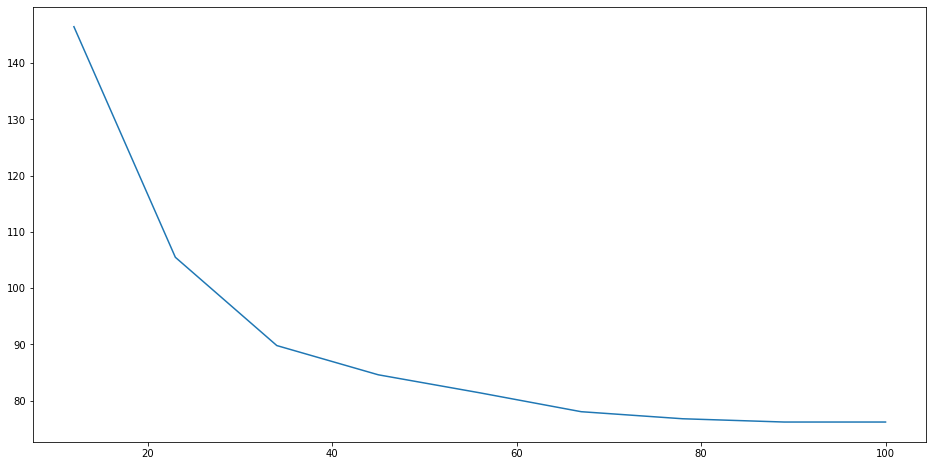

In [146]:
plt.figure(figsize=(16,8))
plt.plot(epsilon,means)
plt.show()


We observe than the bigger epsilon is, the less there are infinite distances in the matrix, wich is coherent